# General Idea
![ETL + Filtering](doc/integration_workflow_small.png)

## 1. Extract, Transform, Load from PharmGKB

In [2]:
import pandas as pd
import itertools
import urllib2
import json
from ipywidgets import interact
from Bio import Entrez
import networkx as nx
from nxpd import draw, nxpdParams
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
BASE_PATH = 'data/'
URI_LABEL_API = 'https://api.pharmgkb.org/v1/data/label/%s?view=max'
URI_NCBI_API = 'https://www.ncbi.nlm.nih.gov/gene/%s'
ORTHOLOG_TERM = 'ortholog_gene_%s[group]'

In [3]:
df_genes = pd.read_csv(BASE_PATH + 'genes.tsv', sep='\t')
df_drugs = pd.read_csv(BASE_PATH + 'drugs.tsv', sep='\t')
df_relationships = pd.read_csv(BASE_PATH + 'drugLabels.byGene.tsv', sep='\t')

In [4]:
df_relationships.head(5)

,Gene ID,Gene Symbol,Label IDs,Label Names
0,PA267,ABCB1,PA166123409;PA166159586,EMA Label for aliskiren and ABCB1;HCSC Label f...
1,PA36144,ABI1,PA166127660;PA166127682;PA166127693;PA166129527,"HCSC Label for dasatinib and ABI1,BCR;HCSC Lab..."
2,PA24413,ABL1,PA166117941;PA166104914;PA166104926;PA16610533...,"EMA Label for bosutinib and ABL1,BCR;EMA Label..."
3,PA24414,ABL2,PA166104825,"FDA Label for valproic acid and ABL2,ASL,ASS1,..."
4,PA39,ADRB2,PA166104779,EMA Label for indacaterol and ADRB2


In [5]:
def get_drug_gene_tuples(drug_details, gene_details):
    drugs = drug_details.split(',')
    genes = gene_details.split(',')
    drug_gene_tuples = list()
    for drug_gene in list(itertools.product(drugs, genes)):
        drug_gene_tuples.append( (drug_gene[0], drug_gene[1]) )
    return drug_gene_tuples

In [6]:
%%time

df_drugs_genes = pd.DataFrame(columns=['Label ID', 'Drug Name', 'Gene Symbol'])

for values in df_relationships[['Label IDs', 'Label Names']].values:
    label_IDs = values[0].split(';')
    label_details = values[1].split(';')
    for i, label in enumerate(label_IDs):
        tokenized_details = label_details[i].split()
        drug_details = ' '.join(tokenized_details[(tokenized_details.index('for') + 1):tokenized_details.index('and')])
        gene_details = tokenized_details[tokenized_details.index('and') + 1]
        for drug_gene in get_drug_gene_tuples(drug_details, gene_details):
            df_drugs_genes = df_drugs_genes.append({ 'Label ID': label,
                                                     'Drug Name': drug_gene[0],
                                                     'Gene Symbol' : drug_gene[1] }, ignore_index=True)

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 6.91 µs


In [7]:
print 'Length: %s' %len(df_drugs_genes)

Length: 1297


In [8]:
df_drugs_genes = df_drugs_genes.drop_duplicates(subset=['Label ID', 'Drug Name', 'Gene Symbol'])
print 'Length: %s' %len(df_drugs_genes)

Length: 619


In [9]:
df_genes_proj = df_genes[['PharmGKB Accession Id', 'Name', 'Symbol', 'Cross-references']]

df_total = df_drugs_genes.merge(df_genes_proj, left_on='Gene Symbol', right_on='Symbol', how='outer').dropna()
df_total['NCBI'] = df_total['Cross-references'].apply(lambda x: x.split(',')[0])

df_total = df_total.drop(['Symbol', 'Cross-references'], axis=1)
df_total = df_total.rename(columns = {'PharmGKB Accession Id': 'Gene ID', 'Name': 'Gene Name'})

In [10]:
len(df_total)

619

In [11]:
df_total.head(5)

,Label ID,Drug Name,Gene Symbol,Gene ID,Gene Name,NCBI
0,PA166123409,aliskiren,ABCB1,PA267,"ATP-binding cassette, sub-family B (MDR/TAP), ...",NCBI Gene:5243
1,PA166159586,aliskiren,ABCB1,PA267,"ATP-binding cassette, sub-family B (MDR/TAP), ...",NCBI Gene:5243
2,PA166127660,dasatinib,ABI1,PA36144,abl-interactor 1,NCBI Gene:10006
3,PA166127682,imatinib,ABI1,PA36144,abl-interactor 1,NCBI Gene:10006
4,PA166127693,nilotinib,ABI1,PA36144,abl-interactor 1,NCBI Gene:10006


In [12]:
df_drugs.head(2)

,PharmGKB Accession Id,Name,Generic Names,Trade Names,Brand Mixtures,Type,Cross-references,SMILES,InChI,Dosing Guideline,External Vocabulary
0,PA165820585,"1,7-dimethylxanthine","17X,""paraxanthine""",NaN,NaN,Drug,PubChem Compound:4687,NaN,NaN,No,NaN
1,PA451991,1-methyloxy-4-sulfone-benzene,NaN,NaN,NaN,Drug,"DrugBank:DB03033,""PDB:MSB"",""PubChem Compound:3...",COC1=CC=C(C=C1)S(=O)=O,InChI=1S/C7H8O3S/c1-10-6-2-4-7(5-3-6)11(8)9/h2...,No,NaN


In [13]:
for name in df_total['Drug Name']:
    if not len(df_drugs['Name'].loc[ df_drugs['Name'] == name ]):
        print name

aripiprazole lauroxil


In [14]:
df_total.loc[ df_total['Drug Name'] == 'aripiprazole lauroxil' ]

,Label ID,Drug Name,Gene Symbol,Gene ID,Gene Name,NCBI
257,PA166161219,aripiprazole lauroxil,CYP2D6,PA128,"cytochrome P450, family 2, subfamily D, polype...",NCBI Gene:1565


In [15]:
df_drugs_proj = df_drugs[['PharmGKB Accession Id', 'Name', 'Generic Names']]

df_total = df_total.merge(df_drugs_proj, left_on='Drug Name', right_on='Name', how='outer').dropna(subset=['Drug Name'])

df_total = df_total.drop(['Name'], axis=1)
df_total = df_total.rename(columns = {'PharmGKB Accession Id': 'Drug ID', 'Generic Names': 'Drug Generic Names'})

In [16]:
df_total.head(5)

,Label ID,Drug Name,Gene Symbol,Gene ID,Gene Name,NCBI,Drug ID,Drug Generic Names
0,PA166123409,aliskiren,ABCB1,PA267,"ATP-binding cassette, sub-family B (MDR/TAP), ...",NCBI Gene:5243,PA143487910,"Rasilez,""SPP 100"",""aliskiren"""
1,PA166159586,aliskiren,ABCB1,PA267,"ATP-binding cassette, sub-family B (MDR/TAP), ...",NCBI Gene:5243,PA143487910,"Rasilez,""SPP 100"",""aliskiren"""
2,PA166127660,dasatinib,ABI1,PA36144,abl-interactor 1,NCBI Gene:10006,PA162372878,"BMS-354825,""dasatinib"""
3,PA166127660,dasatinib,BCR,PA25321,breakpoint cluster region,NCBI Gene:613,PA162372878,"BMS-354825,""dasatinib"""
4,PA166104914,dasatinib,BCR,PA25321,breakpoint cluster region,NCBI Gene:613,PA162372878,"BMS-354825,""dasatinib"""


In [17]:
print '# of Labels: %s' %len(df_total)
print '# of Genes: %s' %len(df_total['Gene ID'].unique())
print '# of Drugs: %s' %len(df_total['Drug Name'].unique())

# of Labels: 619
# of Genes: 91
# of Drugs: 226


In [18]:
def fetch_label(label):
    print '.',
    try:
        fetched_label = json.load(urllib2.urlopen(URI_LABEL_API %(label)))
        return fetched_label['summaryMarkdown']['markdown']
    except:
        return 'Failed to fetch summary data for label %s' %(label)

In [19]:
%%time

df_total['Label Summary'] = df_total.apply(lambda row: fetch_label(row['Label ID']), axis=1)

CPU times: user 3 µs, sys: 3 µs, total: 6 µs
Wall time: 5.01 µs
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

## 2. Filtering Interface

Keyword examples: leukemia, breast cancer, lung cancer, cardiovascular, HIV, malaria.

In [4]:
# df_total.to_csv('aggregated_data_2.tsv', sep='\t', encoding='utf-8')
df_total = pd.read_csv('aggregated_data_2.tsv', sep='\t')

In [5]:
df_filtered = None
global_kw = None

def filtering_interface(kw, field):
    global df_filtered
    global global_kw
    global_kw = kw
    df_filtered = df_total[ df_total[field].str.contains(kw) ]
    filtered_genes = df_filtered['Gene Symbol'].unique()
    filtered_drugs = df_filtered['Drug Name'].unique()
    print '\n\n'.join(['%s drug labels found:' %(len(df_filtered)),
                     '%s genes: %s' %(len(filtered_genes), filtered_genes),
                     '%s drugs: %s' %(len(filtered_drugs), filtered_drugs)])
    print '\n==============================================================================================\n'
    print df_filtered['Label Summary']

pd.options.display.max_colwidth = 250

field_options = df_total.columns.values.tolist()[1:]
field_options[0],field_options[-1] = field_options[-1],field_options[0]
interact(filtering_interface, kw='leukemia', field=field_options)

55 drug labels found:

10 genes: ['CYP2D6' 'ESR1' 'ESR2' 'F2' 'F5' 'ERBB2' 'MKI67' 'PGR' 'HLA-DQA1'
 'HLA-DRB1']

11 drugs: ['tamoxifen' 'everolimus' 'palbociclib' 'fulvestrant' 'anastrozole'
 'exemestane' 'letrozole' 'lapatinib' 'pertuzumab' 'trastuzumab'
 'trastuzumab emtansine']


340    The product monograph for tamoxifen states that it is indicated for treatment of early breast cancer in women with estrogen receptor positive tumors. It also notes that individuals with low CYP2D6 activity (or using CYP2D6 inhibitors) may have re...
341    The product monograph for tamoxifen states that it is indicated for treatment of early breast cancer in women with estrogen receptor positive tumors. It also notes that individuals with low CYP2D6 activity (or using CYP2D6 inhibitors) may have re...
342                                                                                                    Tamoxifen is an anti-estrogen used in the treatment and prevention of breast neoplasms particularl

In [6]:
cached = dict() #Avoid unnecessary querying

def fetch_orthologs(NCBI):
    search_term = ORTHOLOG_TERM %(NCBI.split(':')[1])
    if search_term in cached:
        return cached[search_term]
    
    search_results = dict()
    print 'Fetching orthologs with term: %s' %search_term
    handle = Entrez.esearch(db='gene', sort='relevance', retmax='10000', retmode='xml', term=search_term)
    orthologs = Entrez.read(handle)
    search_results['Count'] = orthologs['Count']
    search_results['IdList'] = orthologs['IdList']
    
    handle.close()    
    cached[search_term] = search_results   
    return search_results

In [7]:
df_filtered['Ortholog IDs'] = df_filtered.apply(lambda x: fetch_orthologs(x['NCBI']), axis=1)

Fetching orthologs with term: ortholog_gene_1565[group]


/Users/victorbursztyn/Documents/PESC/MSc/v1/venv/lib/python2.7/site-packages/Bio/Entrez/__init__.py:559: UserWarning: 
Email address is not specified.

To make use of NCBI's E-utilities, NCBI requires you to specify your
email address with each request.  As an example, if your email address
is A.N.Other@example.com, you can specify it as follows:
   from Bio import Entrez
   Entrez.email = 'A.N.Other@example.com'
In case of excessive usage of the E-utilities, NCBI will attempt to contact
a user at the email address provided before blocking access to the
E-utilities.
  E-utilities.""", UserWarning)


Fetching orthologs with term: ortholog_gene_2099[group]
Fetching orthologs with term: ortholog_gene_2100[group]
Fetching orthologs with term: ortholog_gene_2147[group]
Fetching orthologs with term: ortholog_gene_2153[group]
Fetching orthologs with term: ortholog_gene_2064[group]
Fetching orthologs with term: ortholog_gene_4288[group]
Fetching orthologs with term: ortholog_gene_5241[group]
Fetching orthologs with term: ortholog_gene_3117[group]
Fetching orthologs with term: ortholog_gene_3123[group]


/Users/victorbursztyn/Documents/PESC/MSc/v1/venv/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [8]:
orthologs_count = 0

for search_results in cached:
    orthologs_count += int(cached[search_results]['Count'])

print '************************************'
print '* Fetch and analyze %s orthologs? *' %orthologs_count
print '************************************'

************************************
* Fetch and analyze 1423 orthologs? *
************************************


In [9]:
cached_2 = dict() #Avoid unnecessary querying (2)

def fetch_detailed_orthologs(NCBI, ortholog_ids):
    if NCBI in cached_2:
        return cached_2[NCBI]
    
    ortholog_ids = ortholog_ids['IdList']
    print 'Fetching %s orthologs' %len(ortholog_ids)
    handle = Entrez.efetch('gene', id=','.join(ortholog_ids), retmode='xml')
    fetch_results = Entrez.read(handle)
    
    handle.close()
    cached_2[NCBI] = fetch_results 
    return fetch_results

In [10]:
df_filtered['Ortholog Details'] = df_filtered.apply(lambda x:
                                                    fetch_detailed_orthologs(x['NCBI'], x['Ortholog IDs']),
                                                    axis=1)

Fetching 109 orthologs
Fetching 186 orthologs
Fetching 187 orthologs
Fetching 198 orthologs
Fetching 191 orthologs
Fetching 168 orthologs
Fetching 172 orthologs
Fetching 192 orthologs
Fetching 11 orthologs
Fetching 9 orthologs


/Users/victorbursztyn/Documents/PESC/MSc/v1/venv/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [11]:
df_filtered.to_csv('filtered_for_%s.tsv' %global_kw, sep='\t', encoding='utf-8')

In [12]:
all_genomas = set()

def add_orthologs_as_nodes():
    for detailed_orthologs in df_filtered['Ortholog Details']:
        for ortholog in detailed_orthologs:
            genoma = ortholog['Entrezgene_source']['BioSource']['BioSource_org']['Org-ref']['Org-ref_taxname']
            all_genomas.add(genoma)
            G.add_node(genoma, color='#550000', style='filled', fillcolor='#ffaaaa')

In [13]:
def add_genes_as_nodes():
    for gene in df_filtered['Gene Symbol']:
        G.add_node(gene, color='#074600', style='filled', fillcolor='#92D18B')

In [14]:
def connect_genes_to_orthologs():
    for row in df_filtered[['Gene Symbol','Ortholog Details']].iterrows():
        gene = row[1]['Gene Symbol']
        for ortholog in row[1]['Ortholog Details']:
            genoma = ortholog['Entrezgene_source']['BioSource']['BioSource_org']['Org-ref']['Org-ref_taxname']
            G.add_edge(genoma, gene, color='#777777', style='dashed')

In [15]:
def add_drugs_as_nodes():
    for drug in df_filtered['Drug Name']:
        G.add_node(drug, color='#022735', style='filled', fillcolor='#6D92A0')

In [16]:
def connect_drugs_to_genes():
    for row in df_filtered[['Gene Symbol','Drug Name']].iterrows():
        gene = row[1]['Gene Symbol']
        drug = row[1]['Drug Name']
        G.add_edge(gene, drug, color='#777777', style='dashed')

In [17]:
def remove_low_degree_orthologs(threshold):
    low_degree_nodes = [node for node, degree in G.degree().items() if degree < threshold and node in all_genomas]
    G.remove_nodes_from(low_degree_nodes)

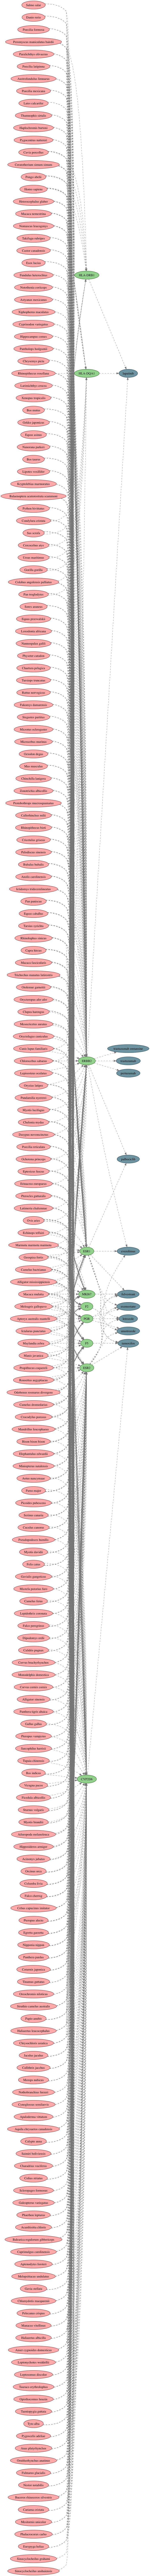

In [18]:
nxpdParams['show'] = 'ipynb'

G = None

def draw_network(threshold):
    global G
    G = nx.DiGraph()
    G.graph['rankdir'] = 'LR'
    G.graph['dpi'] = 80
    
    add_orthologs_as_nodes()
    add_genes_as_nodes()
    connect_genes_to_orthologs()
    add_drugs_as_nodes()
    connect_drugs_to_genes()
    if threshold:
        remove_low_degree_orthologs(threshold=threshold)
    return draw(G)

draw_network(threshold=0)

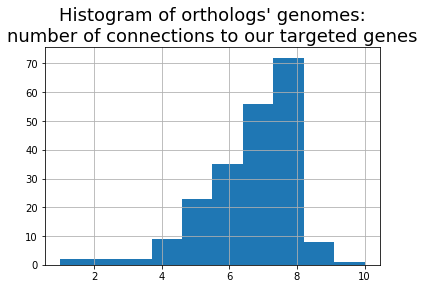

In [19]:
fig = plt.figure()
ortholog_degrees = [degree for node, degree in G.degree().items() if node in all_genomas]
pd.DataFrame(ortholog_degrees).hist()
plt.title('Histogram of orthologs\' genomes:\nnumber of connections to our targeted genes', fontsize=18)
plt.show()

Removing genomes with less than 9 connections to our targeted genes and drawing the network


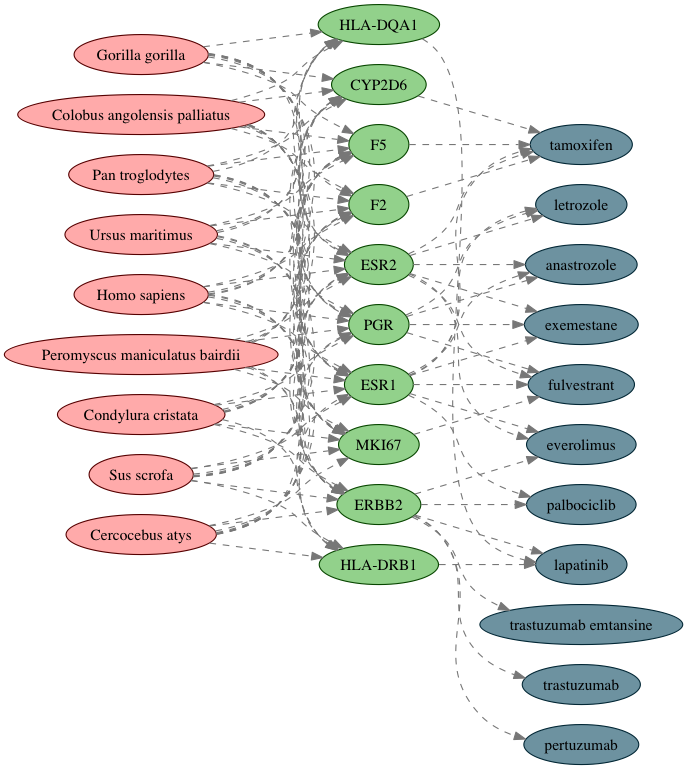

In [21]:
threshold_range = sorted(ortholog_degrees)

def node_removal_interface(threshold=threshold_range[-1]):
    print 'Removing genomes with less than %s connections to our targeted genes and drawing the network' %threshold
    return draw_network(threshold=threshold)

interact(node_removal_interface, threshold=(0, threshold_range[-1]))